In [1]:
# Install required libs
#!pip install -U segmentation-models-pytorch albumentations --user 

In [2]:
#!pip uninstall -y segmentation-models-pytorch

## Loading data

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [4]:
DATA_DIR = './data/triffid_cleaned_data/'

In [5]:
%pwd

'/home/analiza_obrazu/Projects/triffid/segmentation_models.pytorch/examples'

In [6]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

In [7]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [8]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [9]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['background','stalk']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id[:-4] + '_color_mask.png') for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        # extract certain classes from mask (e.g. cars)
        masks = [(mask != 0) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

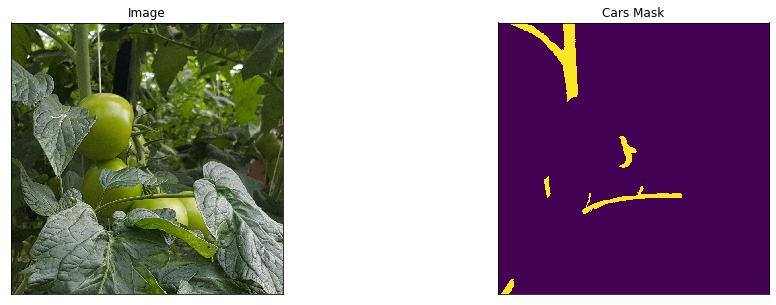

In [10]:
# Lets look at data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['stalk'])

image, mask = dataset[4] # get some sample

visualize(
    image=image, 
    cars_mask=mask.squeeze(),
)

### Augmentations

Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.  
If you not familiar with such trick read some of these articles:
 - [The Effectiveness of Data Augmentation in Image Classification using Deep
Learning](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)
 - [Data Augmentation | How to use Deep Learning when you have Limited Data](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced)
 - [Data Augmentation Experimentation](https://towardsdatascience.com/data-augmentation-experimentation-3e274504f04b)

Since our dataset is very small we will apply a large number of different augmentations:
 - horizontal flip
 - affine transforms
 - perspective transforms
 - brightness/contrast/colors manipulations
 - image bluring and sharpening
 - gaussian noise
 - random crops

All this transforms can be easily applied with [**Albumentations**](https://github.com/albu/albumentations/) - fast augmentation library.
For detailed explanation of image transformations you can look at [kaggle salt segmentation exmaple](https://github.com/albu/albumentations/blob/master/notebooks/example_kaggle_salt.ipynb) provided by [**Albumentations**](https://github.com/albu/albumentations/) authors.

In [11]:
import albumentations as albu

In [12]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        #albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        
        #albu.RandomCrop(height=320, width=320, always_apply=True),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        
        albu.augmentations.transforms.Resize(640,800)
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        #albu.PadIfNeeded(384, 480),
        
        albu.augmentations.transforms.Resize(640,800)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

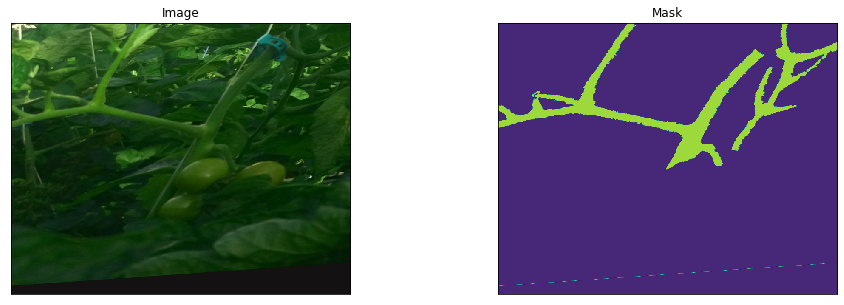

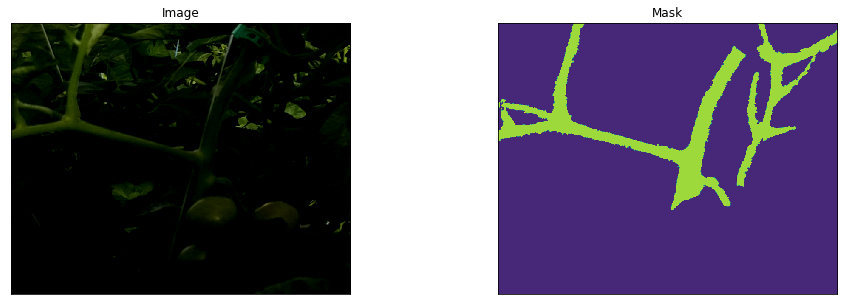

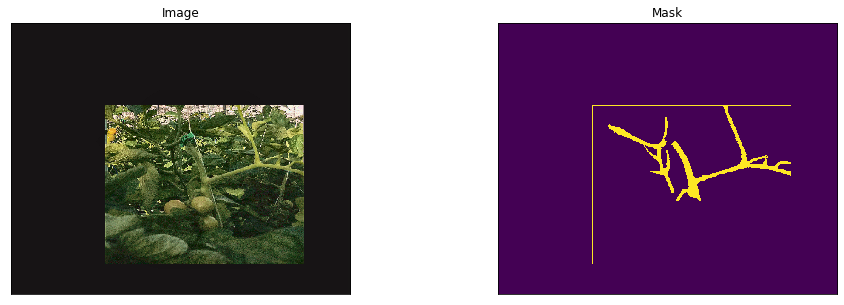

In [13]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    classes=['stalk'],
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[1]
    visualize(image=image, mask=mask.squeeze(-1))

## Create model and train

In [14]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [15]:
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['stalk']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [16]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

/home/analiza_obrazu/anaconda3/envs/triffid_segmentation/lib/python3.6/site-packages/albumentations/augmentations/transforms.py:2908: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  "Using lambda is incompatible with multiprocessing. "


In [17]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [18]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [19]:
# train model for 40 epochs

max_score = 0

for i in range(0, 100):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    #import pdb; pdb.set_trace()
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 10/10 [00:00<00:00, 11.99it/s, dice_loss - 0.5409, iou_score - 0.3083]


/home/analiza_obrazu/anaconda3/envs/triffid_segmentation/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type FPN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/analiza_obrazu/anaconda3/envs/triffid_segmentation/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type SENetEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/analiza_obrazu/anaconda3/envs/triffid_segmentation/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/analiza_obrazu/anaconda3/envs/triffid_segmentation/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Cou

Model saved!

Epoch: 1
valid: 100%|██████████| 10/10 [00:00<00:00, 11.80it/s, dice_loss - 0.4297, iou_score - 0.415]
Model saved!

Epoch: 2
valid: 100%|██████████| 10/10 [00:00<00:00, 11.76it/s, dice_loss - 0.3702, iou_score - 0.4739]
Model saved!

Epoch: 3
valid: 100%|██████████| 10/10 [00:00<00:00, 11.93it/s, dice_loss - 0.4471, iou_score - 0.3941]

Epoch: 4
valid: 100%|██████████| 10/10 [00:00<00:00, 11.96it/s, dice_loss - 0.3857, iou_score - 0.4569]

Epoch: 5
valid: 100%|██████████| 10/10 [00:00<00:00, 11.84it/s, dice_loss - 0.3489, iou_score - 0.4949]
Model saved!

Epoch: 6
valid: 100%|██████████| 10/10 [00:00<00:00, 11.96it/s, dice_loss - 0.3459, iou_score - 0.5002]
Model saved!

Epoch: 7
valid: 100%|██████████| 10/10 [00:00<00:00, 11.84it/s, dice_loss - 0.3387, iou_score - 0.5056]
Model saved!

Epoch: 8
valid: 100%|██████████| 10/10 [00:00<00:00, 11.92it/s, dice_loss - 0.3279, iou_score - 0.5194]
Model saved!

Epoch: 9
valid: 100%|██████████| 10/10 [00:00<00:00, 11.89it/s, dice_

valid: 100%|██████████| 10/10 [00:00<00:00, 11.89it/s, dice_loss - 0.285, iou_score - 0.5672]

Epoch: 82
valid: 100%|██████████| 10/10 [00:00<00:00, 11.61it/s, dice_loss - 0.292, iou_score - 0.5595]

Epoch: 83
valid: 100%|██████████| 10/10 [00:00<00:00, 11.67it/s, dice_loss - 0.2876, iou_score - 0.5632]

Epoch: 84
valid: 100%|██████████| 10/10 [00:00<00:00, 11.59it/s, dice_loss - 0.2858, iou_score - 0.5655]

Epoch: 85
valid: 100%|██████████| 10/10 [00:00<00:00, 11.77it/s, dice_loss - 0.284, iou_score - 0.5668]

Epoch: 86
valid: 100%|██████████| 10/10 [00:00<00:00, 11.82it/s, dice_loss - 0.2832, iou_score - 0.5675]

Epoch: 87
valid: 100%|██████████| 10/10 [00:00<00:00, 11.83it/s, dice_loss - 0.2804, iou_score - 0.571]

Epoch: 88
valid: 100%|██████████| 10/10 [00:00<00:00, 11.70it/s, dice_loss - 0.2756, iou_score - 0.5773]
Model saved!

Epoch: 89
valid: 100%|██████████| 10/10 [00:00<00:00, 11.90it/s, dice_loss - 0.2764, iou_score - 0.5753]

Epoch: 90
valid: 100%|██████████| 10/10 [00:00<

## Test best saved model

In [20]:
# load best saved checkpoint
best_model = torch.load('./best_model.pth')

In [21]:
# create test dataset
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

In [22]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 4/4 [00:00<00:00,  6.24it/s, dice_loss - 0.3036, iou_score - 0.5396]


## Visualize predictions

In [23]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir, 
    classes=CLASSES,
)

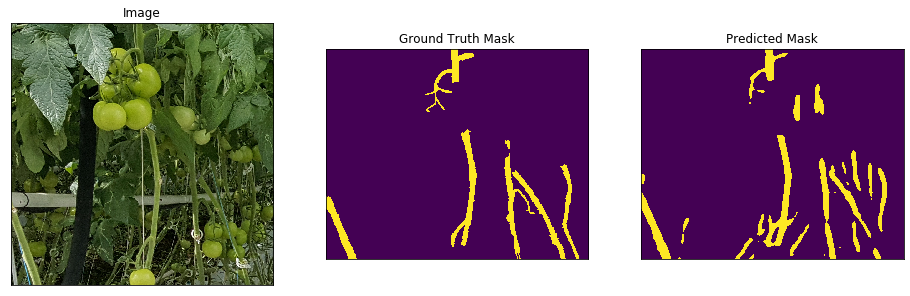

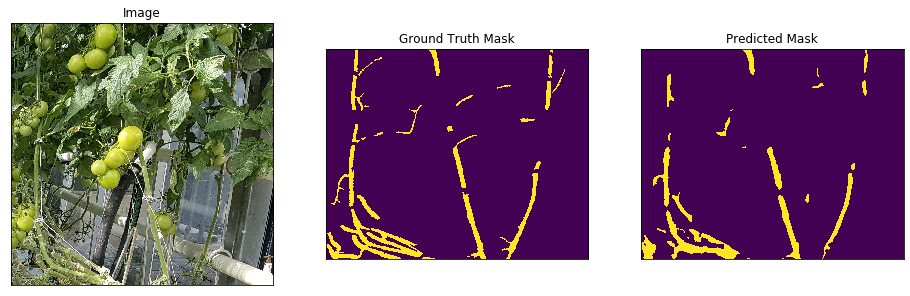

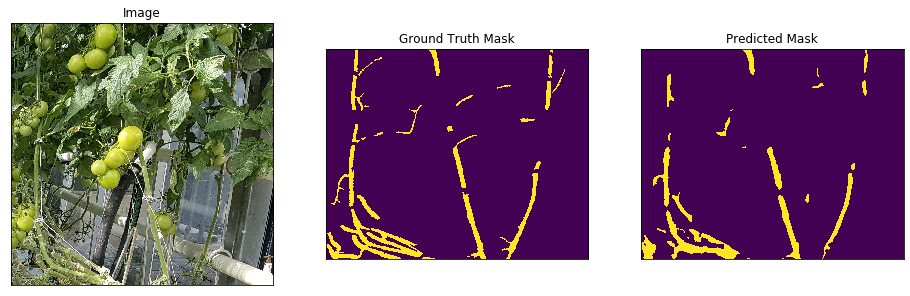

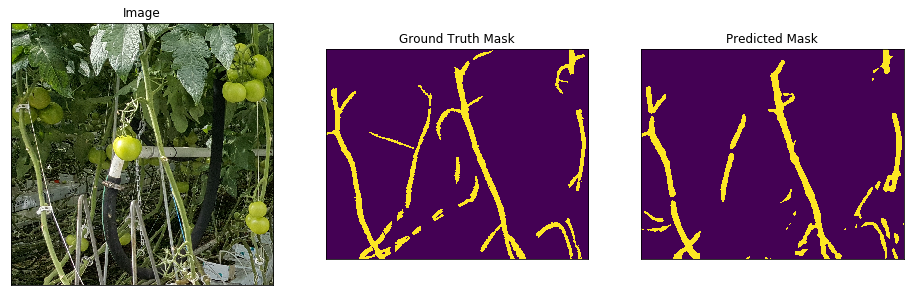

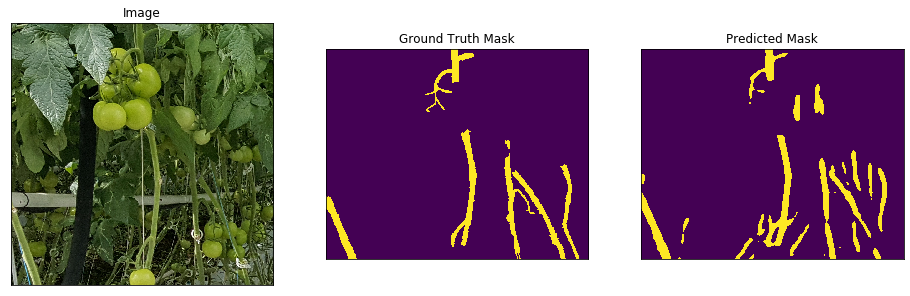

In [24]:
for i in range(5):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )

In [ ]:
import os

path = 'data/Stalk segmentation/'

files = []
masks = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path):
    for file in f:
        if ("color" in file):
            masks.append(file)
        else:
            files.append(file)

masks


In [ ]:
files

In [ ]:
import shutil

for file in files:
    for mask in masks:
        if (file.lower()[:-4] in mask):
            print(file)
            shutil.copy2('data/Stalk segmentation/' + file, 'data/Stalk segmentation/cleaned_data/images')
            shutil.copy2('data/Stalk segmentation/' + mask, 'data/Stalk segmentation/cleaned_data/masks/')
            

In [ ]:
import cv2

In [ ]:
maska = cv2.imread('data/triffid_cleaned_data/trainannot/20160921_132244_1_color_mask.png')

In [ ]:
maska.shape